# Benchmarking RL methods to solve BlackJack

Thomas Lemercier & Gaspard Berthelier

## Imports

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/RL/blackjack

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL/blackjack


In [2]:
import gym
import time
from tqdm import tqdm
import numpy as np

In [3]:
from src.utils.general import state_to_index, get_num_states, state_to_tensor_encoding
from src.utils.data_struct import Transition
from src.agents import Agent
from src.utils.visualization import plot_policy_simple_blackjack


def play_episode(env: gym.Env, agent: Agent, render: bool = False, array_encoding: bool = False):
    """plays one episode of given agent"""
    state = env.reset()
    if render:
        env.render()
    if array_encoding:
        state = state_to_tensor_encoding(state, env.observation_space)
    else:
        state = state_to_index(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        if array_encoding:
            next_state = state_to_tensor_encoding(next_state, env.observation_space)
        else:
            next_state = state_to_index(next_state, env.observation_space)
        state = next_state
    return reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def play_policy(env: gym.Env, agent: Agent, n_test_episodes: int,  array_encoding: bool = False):
  """test the agent's policy on multiple episodes, prints the last one"""
  rewards = [play_episode(env, agent, render= i == n_test_episodes-1, array_encoding=array_encoding) for i in range(n_test_episodes)]
  rewards = np.array(rewards)
  n_wins = np.sum(rewards == 1)
  n_draws = np.sum(rewards == 0)
  print(f"Win rate: {n_wins / n_test_episodes:.4f}")
  print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
n_episodes = 500_000
n_test_episodes = 100_000

## Infinite Deck

Infinite deck, aka probabilities of drawing each card remains constant

In [6]:
from src.envs import InfiniteSimpleBlackjack

### Random

Random agent which takes action randomly at each step

In [7]:
from src.agents import RandomAgent

env = InfiniteSimpleBlackjack(seed=42)
agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes)


Player's hand: [10, 9] (value: 19)
Dealer's hand: [4, 2] (value: 6)
Current state: [19  4  0]


Player's hand: [10, 9] (value: 19)
Dealer's hand: [4, 2, 7, 10] (value: 23)
Current state: [19  4  0]

Win rate: 0.2836
Draw rate: 0.0419


### Monte Carlo

In [8]:
from src.agents import MonteCarloAgent

def main_monte_carlo(env: gym.Env, agent: MonteCarloAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        episode = agent.generate_episode(env)
        reward = episode[-1][2]
        agent.step(episode)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1
    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")
    print(f"\nTime taken: {time.time() - start:.2f} seconds")

100%|██████████| 500000/500000 [00:54<00:00, 9096.96it/s]


Win rate: 0.41
Draw rate: 0.09

Time taken: 54.97 seconds


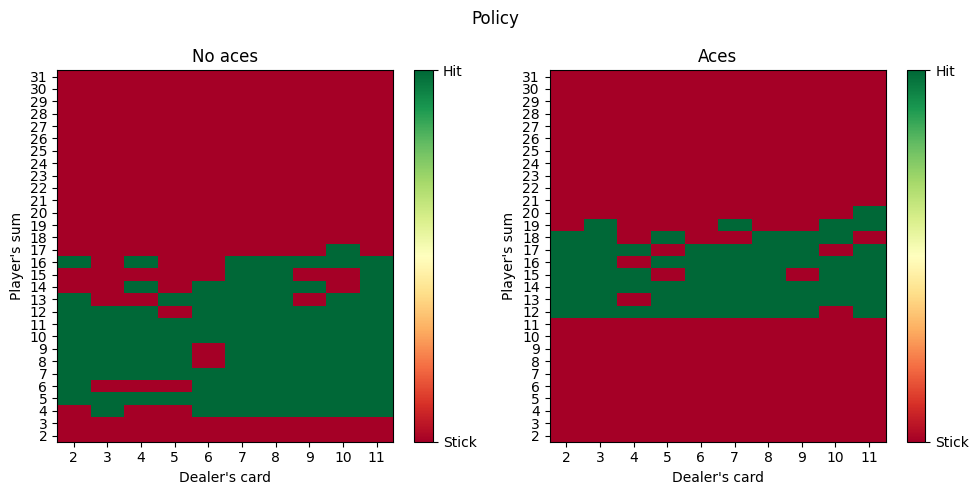

Win rate: 0.4149
Draw rate: 0.0873


In [9]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.visualization import plot_policy_simple_blackjack
from src.utils.data_struct import MonteCarloParameters

n_episodes = 500_000
env = InfiniteSimpleBlackjack(seed=42)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
monte_carlo_parameters = MonteCarloParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = MonteCarloAgent(monte_carlo_parameters, exploration)

main_monte_carlo(env, agent, n_episodes)

policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

n_test_episodes = 10000
env = InfiniteSimpleBlackjack(seed=666)
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

100%|██████████| 500000/500000 [00:33<00:00, 14959.66it/s]


Win rate: 0.34
Draw rate: 0.06

Time taken: 33.43 seconds


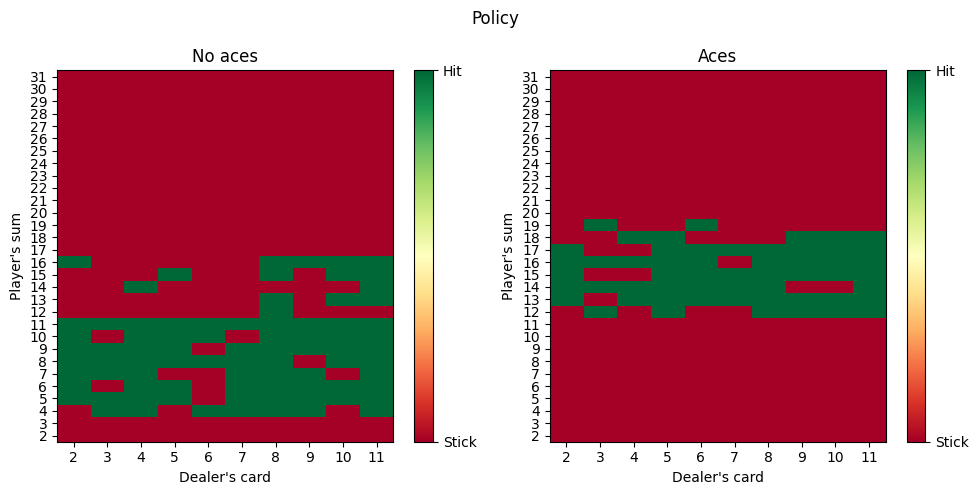

Win rate: 0.4111
Draw rate: 0.0762


In [10]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.visualization import plot_policy_simple_blackjack
from src.utils.data_struct import MonteCarloParameters

n_episodes = 500_000
env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
monte_carlo_parameters = MonteCarloParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = MonteCarloAgent(monte_carlo_parameters, exploration)

main_monte_carlo(env, agent, n_episodes)

policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)


n_test_episodes = 10000
env = InfiniteSimpleBlackjack(seed=666)
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

### Sarsa

In [11]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent

def main_sarsa(env: gym.Env, agent: SarsaAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        action = agent.act(state)
        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            action = agent.act(next_state)
            state = next_state
            agent.step(transition, action)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")

    print(f"\nTime taken: {time.time() - start:.4f} seconds")

100%|██████████| 500000/500000 [01:30<00:00, 5532.65it/s]


Win rate: 0.3585
Draw rate: 0.0768

Time taken: 90.3787 seconds


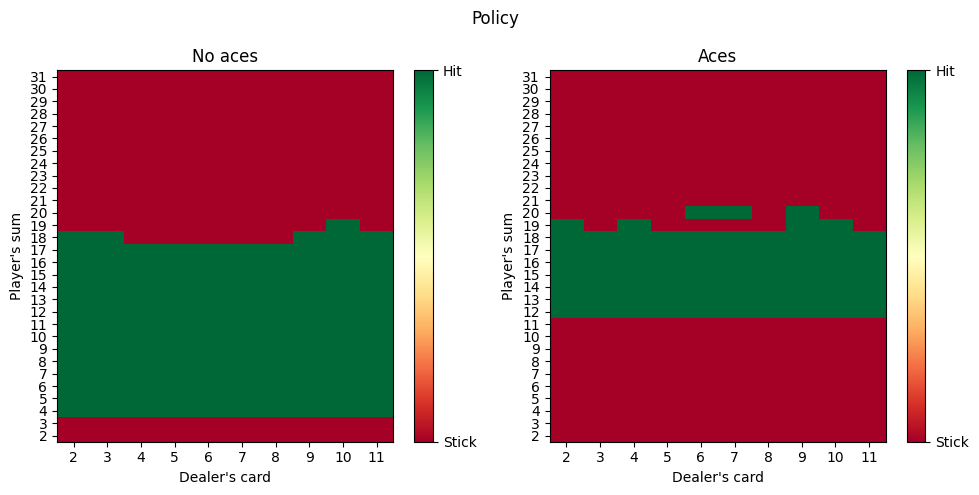


Player's hand: [4, 10] (value: 14)
Dealer's hand: [2, 10] (value: 12)
Current state: [14  2  0]


Player's hand: [4, 10, 10] (value: 24)
Dealer's hand: [2, 10] (value: 12)
Current state: [24  2  0]

Win rate: 0.3543
Draw rate: 0.0727


In [12]:
#ucb
env = InfiniteSimpleBlackjack(seed=42)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)
play_policy(env, agent, n_test_episodes)

In [13]:
#epsilon greedy 0.8
env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [00:27<00:00, 18157.15it/s]


Win rate: 0.3309
Draw rate: 0.0625

Time taken: 27.5435 seconds

Player's hand: [6, 3] (value: 9)
Dealer's hand: [2, 11] (value: 13)
Current state: [9 2 0]


Player's hand: [6, 3, 4] (value: 13)
Dealer's hand: [2, 11] (value: 13)
Current state: [13  2  0]


Player's hand: [6, 3, 4, 7] (value: 20)
Dealer's hand: [2, 11] (value: 13)
Current state: [20  2  0]


Player's hand: [6, 3, 4, 7] (value: 20)
Dealer's hand: [2, 11, 10, 11, 3] (value: 17)
Current state: [20  2  0]

Win rate: 0.3986
Draw rate: 0.0859


In [14]:
#epsilon greedy 0.2
env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.2, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [00:30<00:00, 16509.25it/s]


Win rate: 0.3684
Draw rate: 0.0781

Time taken: 30.2970 seconds

Player's hand: [10, 8] (value: 18)
Dealer's hand: [3, 2] (value: 5)
Current state: [18  3  0]


Player's hand: [10, 8] (value: 18)
Dealer's hand: [3, 2, 6, 7] (value: 18)
Current state: [18  3  0]

Win rate: 0.3867
Draw rate: 0.0854


### Q Learning

In [15]:
from src.agents import QlearningAgent
from src.utils.data_struct import QlearningParameters

def main_qlearning(env: gym.Env, agent: QlearningAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")
    print(f"\nTime taken: {time.time() - start:.4f} seconds")

100%|██████████| 500000/500000 [01:11<00:00, 7020.64it/s]


Win rate: 0.3666
Draw rate: 0.0796

Time taken: 71.2276 seconds


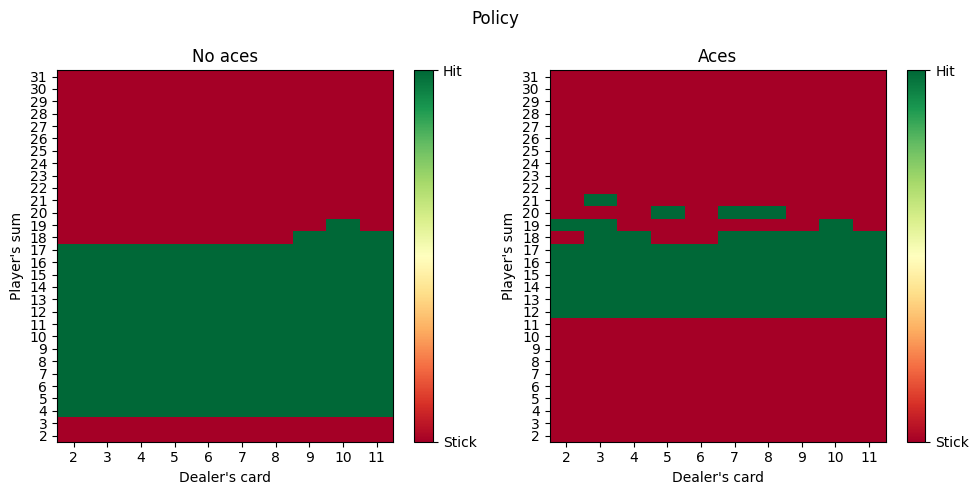


Player's hand: [5, 11] (value: 16)
Dealer's hand: [10, 10] (value: 20)
Current state: [16 10  1]


Player's hand: [5, 11, 11] (value: 17)
Dealer's hand: [10, 10] (value: 20)
Current state: [17 10  1]


Player's hand: [5, 11, 11, 11] (value: 18)
Dealer's hand: [10, 10] (value: 20)
Current state: [18 10  1]


Player's hand: [5, 11, 11, 11, 11] (value: 19)
Dealer's hand: [10, 10] (value: 20)
Current state: [19 10  1]


Player's hand: [5, 11, 11, 11, 11, 10] (value: 19)
Dealer's hand: [10, 10] (value: 20)
Current state: [19 10  0]


Player's hand: [5, 11, 11, 11, 11, 10, 6] (value: 25)
Dealer's hand: [10, 10] (value: 20)
Current state: [25 10  0]

Win rate: 0.3639
Draw rate: 0.0764


In [16]:
#ucb
env = InfiniteSimpleBlackjack(seed=42)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)
play_policy(env, agent, n_test_episodes)

In [17]:
#epsilon greedy 0.8
env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [00:31<00:00, 15741.73it/s]


Win rate: 0.3222
Draw rate: 0.0578

Time taken: 31.7696 seconds

Player's hand: [3, 8] (value: 11)
Dealer's hand: [8, 7] (value: 15)
Current state: [11  8  0]


Player's hand: [3, 8, 8] (value: 19)
Dealer's hand: [8, 7] (value: 15)
Current state: [19  8  0]


Player's hand: [3, 8, 8] (value: 19)
Dealer's hand: [8, 7, 9] (value: 24)
Current state: [19  8  0]

Win rate: 0.3877
Draw rate: 0.0748


In [18]:
#epsilon greedy 0.2

env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.2, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [00:35<00:00, 14174.09it/s]


Win rate: 0.3673
Draw rate: 0.0767

Time taken: 35.2853 seconds

Player's hand: [8, 11] (value: 19)
Dealer's hand: [2, 10] (value: 12)
Current state: [19  2  1]


Player's hand: [8, 11] (value: 19)
Dealer's hand: [2, 10, 10] (value: 22)
Current state: [19  2  1]

Win rate: 0.3906
Draw rate: 0.0800


### DQN

In [19]:
from src.agents.dqn import DQN
from src.utils.general import get_input_dim_encoding
import torch

def main_dqn(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_index(next_state, env.observation_space)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [20]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer
from src.explorations import EpsilonGreedy

n_episodes = 100_000
params = DQNParameters()
env = InfiniteSimpleBlackjack(seed=42)

q_network = MLP(11, 64, env.action_space.n).to(params.device)
target_network = MLP(11, 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.3, 0.9)
agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
play_policy(env, agent, n_test_episodes, array_encoding=True)

  0%|          | 0/100000 [00:00<?, ?it/s]


AttributeError: 'numpy.int64' object has no attribute 'float'

## Simple Finite

In [21]:
from src.envs import SimpleBlackjack
env = SimpleBlackjack(seed=42, packs=4)

### Random

In [22]:
agent = RandomAgent(env.action_space, seed=42)
play_policy(env, agent, n_test_episodes)


Player's hand: [10, 10] (value: 20)
Dealer's hand: [6, 7] (value: 13)
Current state: [20  6  0  2]


Player's hand: [10, 10] (value: 20)
Dealer's hand: [6, 7, 2, 11, 10] (value: 26)
Current state: [20  6  0  2]

Win rate: 0.2827
Draw rate: 0.0432


### Monte Carlo

In [23]:
def main_monte_carlo(env: gym.Env, agent: MonteCarloAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        episode = agent.generate_episode(env)
        reward = episode[-1][2]
        agent.step(episode)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1
    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")
    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [25]:
#UCB
n_episodes = 500_000
env = SimpleBlackjack(seed=42, packs=4)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
monte_carlo_parameters = MonteCarloParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = MonteCarloAgent(monte_carlo_parameters, exploration)

main_monte_carlo(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()

n_test_episodes = 10000
env = InfiniteSimpleBlackjack(seed=666)
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

100%|██████████| 500000/500000 [02:17<00:00, 3633.60it/s]


Win rate: 0.41
Draw rate: 0.08

Time taken: 137.61 seconds
Win rate: 0.3762
Draw rate: 0.0473


In [26]:
n_episodes = 500_000
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
monte_carlo_parameters = MonteCarloParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = MonteCarloAgent(monte_carlo_parameters, exploration)

main_monte_carlo(env, agent, n_episodes)

policy = agent.get_policy()

n_test_episodes = 10000
env = SimpleBlackjack(seed=666, packs=4)
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

100%|██████████| 500000/500000 [01:50<00:00, 4519.66it/s]


Win rate: 0.34
Draw rate: 0.06

Time taken: 110.63 seconds
Win rate: 0.4161
Draw rate: 0.0800


### Sarsa

In [27]:
#ucb
env = SimpleBlackjack(seed=42, packs=4)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)

main_sarsa(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [02:11<00:00, 3798.77it/s]


Win rate: 0.3681
Draw rate: 0.0775

Time taken: 131.6274 seconds

Player's hand: [10, 4] (value: 14)
Dealer's hand: [10, 3] (value: 13)
Current state: [14 10  0  2]


Player's hand: [10, 4, 4] (value: 18)
Dealer's hand: [10, 3] (value: 13)
Current state: [18 10  0  3]


Player's hand: [10, 4, 4, 10] (value: 28)
Dealer's hand: [10, 3] (value: 13)
Current state: [28 10  0  4]

Win rate: 0.3586
Draw rate: 0.0756


In [28]:
#epsilon greedy 0.8
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:14<00:00, 6683.20it/s]


Win rate: 0.3308
Draw rate: 0.0628

Time taken: 74.8201 seconds

Player's hand: [10, 4] (value: 14)
Dealer's hand: [10, 3] (value: 13)
Current state: [14 10  0  2]


Player's hand: [10, 4, 4] (value: 18)
Dealer's hand: [10, 3] (value: 13)
Current state: [18 10  0  3]


Player's hand: [10, 4, 4, 10] (value: 28)
Dealer's hand: [10, 3] (value: 13)
Current state: [28 10  0  4]

Win rate: 0.3738
Draw rate: 0.0829


In [29]:
#epsilon greedy 0.2
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.2, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:15<00:00, 6627.12it/s]


Win rate: 0.3696
Draw rate: 0.0777

Time taken: 75.4594 seconds

Player's hand: [10, 4] (value: 14)
Dealer's hand: [10, 3] (value: 13)
Current state: [14 10  0  2]


Player's hand: [10, 4, 4] (value: 18)
Dealer's hand: [10, 3] (value: 13)
Current state: [18 10  0  3]


Player's hand: [10, 4, 4, 10] (value: 28)
Dealer's hand: [10, 3] (value: 13)
Current state: [28 10  0  4]

Win rate: 0.3701
Draw rate: 0.0840


### Q Learning

In [30]:
#ucb
env = SimpleBlackjack(seed=42, packs=4)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:59<00:00, 4167.97it/s]


Win rate: 0.3741
Draw rate: 0.0809

Time taken: 119.9670 seconds

Player's hand: [10, 4] (value: 14)
Dealer's hand: [10, 3] (value: 13)
Current state: [14 10  0  2]


Player's hand: [10, 4, 4] (value: 18)
Dealer's hand: [10, 3] (value: 13)
Current state: [18 10  0  3]


Player's hand: [10, 4, 4, 10] (value: 28)
Dealer's hand: [10, 3] (value: 13)
Current state: [28 10  0  4]

Win rate: 0.3685
Draw rate: 0.0806


In [31]:
#epsilon greedy 0.8
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:22<00:00, 6075.61it/s]


Win rate: 0.3224
Draw rate: 0.0576

Time taken: 82.3034 seconds

Player's hand: [10, 4] (value: 14)
Dealer's hand: [10, 3] (value: 13)
Current state: [14 10  0  2]


Player's hand: [10, 4, 4] (value: 18)
Dealer's hand: [10, 3] (value: 13)
Current state: [18 10  0  3]


Player's hand: [10, 4, 4, 10] (value: 28)
Dealer's hand: [10, 3] (value: 13)
Current state: [28 10  0  4]

Win rate: 0.3866
Draw rate: 0.0828


In [32]:
#epsilon greedy 0.2
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.2, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:23<00:00, 6000.64it/s]


Win rate: 0.3702
Draw rate: 0.0761

Time taken: 83.3303 seconds

Player's hand: [10, 4] (value: 14)
Dealer's hand: [10, 3] (value: 13)
Current state: [14 10  0  2]


Player's hand: [10, 4, 4] (value: 18)
Dealer's hand: [10, 3] (value: 13)
Current state: [18 10  0  3]


Player's hand: [10, 4, 4, 10] (value: 28)
Dealer's hand: [10, 3] (value: 13)
Current state: [28 10  0  4]

Win rate: 0.3764
Draw rate: 0.0840


## Complete

In [33]:
from src.envs import Blackjack

### Random

In [34]:
from src.agents import RandomAgent

env = Blackjack(seed=42, packs=4)
agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes, array_encoding=True)


Player's hand: [10, 7] (value: 17)
Dealer's hand: [7, 9] (value: 16)
Current state: {'dealer': 7, 'player': [10, 7]}


Player's hand: [10, 7] (value: 17)
Dealer's hand: [7, 9, 5] (value: 21)
Current state: {'dealer': 7, 'player': [10, 7]}

Win rate: 0.2792
Draw rate: 0.0418


### DQN

In [35]:
from src.agents.dqn import DQN
from src.utils.general import get_input_dim_encoding
import torch

def main_dqn(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_encoding(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_encoding(next_state, env.observation_space)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [36]:
n_episodes = 100_000

In [37]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer

env = Blackjack(seed=42, packs=4)
params = DQNParameters()
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.3, 0.9)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

100%|██████████| 100000/100000 [05:26<00:00, 306.08it/s]

Win rate: 0.32
Draw rate: 0.05

Time taken: 326.72 seconds


In [38]:
env = Blackjack(seed=666, packs=4)
play_policy(env, agent, n_test_episodes, array_encoding=True)


Player's hand: [10, 4] (value: 14)
Dealer's hand: [10, 3] (value: 13)
Current state: {'dealer': 10, 'player': [10, 4]}


Player's hand: [10, 4] (value: 14)
Dealer's hand: [10, 3, 4] (value: 17)
Current state: {'dealer': 10, 'player': [10, 4]}

Win rate: 0.3791
Draw rate: 0.0578


In [39]:
#ucb
env = Blackjack(seed=42, packs=4)
params = DQNParameters()
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

env = Blackjack(seed=666, packs=4)
play_policy(env, agent, n_test_episodes, array_encoding=True)

AttributeError: 'Dict' object has no attribute 'high'

### DQN sequence

In [40]:
from src.utils.general import state_to_tensor_sequence

def main(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
        state = next_state
    return reward

In [41]:
params = DQNParameters()
env = Blackjack(seed=42, packs=4)
q_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main(env, agent, n_episodes)

100%|██████████| 100000/100000 [04:59<00:00, 334.19it/s]

Win rate: 0.38
Draw rate: 0.07

Time taken: 299.24 seconds


In [42]:
n_test_episodes = 10000
env = Blackjack(seed=666, packs=4)

rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.4054
Draw rate: 0.0747


### DQN encoding

In [43]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer
from src.explorations import EpsilonGreedy, UCB
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent

In [44]:
params = DQNParameters()
env = Blackjack(seed=42, packs=4)

q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

100%|██████████| 100000/100000 [05:47<00:00, 287.81it/s]

Win rate: 0.34
Draw rate: 0.05

Time taken: 347.45 seconds


In [45]:
def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_encoding(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_encoding(next_state, env.observation_space)
        state = next_state
    return reward

In [46]:
n_test_episodes = 10000
env = Blackjack(seed=666, packs=4)

rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.3782
Draw rate: 0.0536


### DQN embedding

In [47]:
from src.networks import MLPEmbedding
env = Blackjack(seed=42, packs=4)

input_range = env.observation_space["dealer"].high.item() - env.observation_space["dealer"].low.item() + 1

params = DQNParameters(device=torch.device("cpu"))
q_network = MLPEmbedding(1, 64, env.action_space.n, input_range).to(params.device)
target_network = MLPEmbedding(1, 64, env.action_space.n, input_range).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

env = Blackjack(seed=666, packs=4)

n_test_episodes = 10_000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

100%|██████████| 100000/100000 [05:55<00:00, 280.92it/s]


Win rate: 0.34
Draw rate: 0.05

Time taken: 355.98 seconds
Win rate: 0.3782
Draw rate: 0.0536
